In [1]:

from matplotlib import pyplot as plt
import numpy as np
# import geopandas
import pickle
from sklearn.cluster import KMeans

In [2]:
with open('data.pickle', 'rb') as handle:
    d = pickle.load(handle)

## K Means

In [3]:
print(d['lat'][:,0].shape)
print(d['lon'][0].shape)
print(d['all_data'][:,2:].shape)

(99,)
(171,)
(16929, 3)


In [4]:
km = KMeans(n_clusters=3).fit(d['all_data'][:,2:])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [5]:
km.cluster_centers_  # without lat lon coord as "features"

array([[ 7404.66080273,    10.40609735,    94.50486763],
       [10200.05581915,    13.52461066,    89.24058052],
       [ 4753.97303431,    10.36405553,   100.5298358 ]])

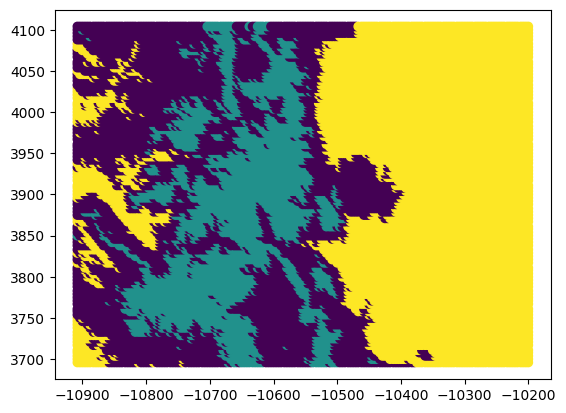

In [6]:
lon = (np.round(d['lon'],2)*100).astype(int).flatten()  # x
lat = (np.round(d['lat'],2)*100).astype(int).flatten()  # y
plt.scatter(lon,lat,c=km.labels_);